### Part 0: Imports, Loading the models, some useful functions

In [10]:
import time
import math
import numpy as np
import sys
import warnings
import torch
import torch.nn as nn
import data
import model as model_lib
import pickle
import glob
from tqdm.notebook import tqdm
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import ttest_rel

In [11]:
SEEDS = {2398, 2399, 2400, 2401, 2402}
#model class ids are NNtype_dims_auxobjweight_attntype
#NNtype: CBRNN: Self-attentive Cue-Based Retrieval/Recurrent NN, LSTM
#hsize: model dimensionality; # of dimensions of hidden state, embeddings, and attention vectors.
#auxobjweight: 0: no aux objective, 1: equal weight of aux label objective and lm objective, 5: aux label objective 5x weight of lm objective
#attn_type: soft: soft attention (default), hard: hard attention (max), none: ablated attention, unif: uniform attention

MODEL_CLASSES = ['cbrnn_256_0_soft', 'cbrnn_256_1_soft', 'cbrnn_256_5_soft',
                 'cbrnn_256_0_hard', 'cbrnn_256_1_hard', 'cbrnn_256_5_hard',
                 'cbrnn_256_0_none', 'cbrnn_256_1_none', 'cbrnn_256_5_none',
                 'cbrnn_256_0_unif', 'cbrnn_256_1_unif', 'cbrnn_256_5_unif']


MODEL_CLASS_ATTRIBS = {'cbrnn_256_0_soft':{'model_type':'cbrnn', 'dims':256, 'aux_weight':0, 'attn_type':'soft', 'description':'256 dimensions, no ccg tagging, soft attention'},
                       'cbrnn_256_1_soft':{'model_type':'cbrnn', 'dims':256, 'aux_weight':1, 'attn_type':'soft', 'description':'256 dimensions, ccg tagging (weight=1), soft attention'},
                       'cbrnn_256_5_soft':{'model_type':'cbrnn', 'dims':256, 'aux_weight':5, 'attn_type':'soft', 'description':'256 dimensions, ccg tagging (weight=5), soft attention'},
                       'cbrnn_256_0_none':{'model_type':'cbrnn', 'dims':256, 'aux_weight':0, 'attn_type':'none', 'description':'256 dimensions, no ccg tagging, no attention mechanism'},
                       'cbrnn_256_1_none':{'model_type':'cbrnn', 'dims':256, 'aux_weight':1, 'attn_type':'none', 'description':'256 dimensions, ccg tagging (weight=1), no attention mechanism'},
                       'cbrnn_256_5_none':{'model_type':'cbrnn', 'dims':256, 'aux_weight':5, 'attn_type':'none', 'description':'256 dimensions, ccg tagging (weight=5), no attention mechanism'},
                       'lstm_256_1_0'    :{'model_type':'lstm', 'dims':256, 'aux_weight':0, 'attn_type':'none', 'description':'1 layer 256dim lstm, no ccg tagging'},
                       'lstm_256_1_1'    :{'model_type':'lstm', 'dims':256, 'aux_weight':1, 'attn_type':'none', 'description':'1 layer 256dim lstm, ccg tagging (weight=1)'},
                       'lstm_256_1_5'    :{'model_type':'lstm', 'dims':256, 'aux_weight':5, 'attn_type':'none', 'description':'1 layer 256dim lstm, ccg tagging (weight=5)'},
                       'lstm_271_2_0'    :{'model_type':'lstm', 'dims':271, 'aux_weight':0, 'attn_type':'none', 'description':'2 layer 271dim lstm, no ccg tagging'},
                       'lstm_271_2_1'    :{'model_type':'lstm', 'dims':271, 'aux_weight':1, 'attn_type':'none', 'description':'2 layer 271dim lstm, ccg tagging (weight=1)'},
                       'lstm_271_2_5'    :{'model_type':'lstm', 'dims':271, 'aux_weight':5, 'attn_type':'none', 'description':'2 layer 271dim lstm, ccg tagging (weight=5)'}}

LSTM_MODEL_CLASSES = ['lstm_256_1_0', 'lstm_256_1_1', 'lstm_256_1_5', #1 layer hidden-state matched models (state-to-state bottleneck benchmark)
                      'lstm_271_2_0', 'lstm_271_2_1', 'lstm_271_2_5'] #2 layer parameter matched models (more passed from state to state, but equal model size to CBRNNs)

MODELS_DIR = './wikitext103_models/'
DATA_DIR = './data/'
VOCAB_FILE = DATA_DIR + 'vocab.txt'
AUX_VOCAB_FILE = DATA_DIR + 'aux_labels.txt'
                 

In [12]:
def load_vocab(fname):
    with open(fname, 'r', encoding='utf-8') as f:
        idx2tok = [x[:-1] for x in f.readlines()][:-1]
    tok2idx = {tok:i for i, tok in enumerate(idx2tok)}
    return idx2tok, tok2idx

vocab_idx2tok, vocab_tok2idx = load_vocab(VOCAB_FILE)
aux_idx2tok, aux_tok2idx = load_vocab(AUX_VOCAB_FILE)

#take a list of token_ids, decode it into a spaced string
def decode_tokens(data, aux=False):
    out_str = ''
    if(aux):
        decode_dict = aux_idx2tok
    else:
        decode_dict = vocab_idx2tok
    for tok in data:
        out_str += decode_dict[tok] + ' '
    return out_str[:-1]

def unk_lower_num(word):
    word = word.replace("-LRB-", '(')
    word = word.replace("-LCB-", '{')
    word = word.replace("-LSB-", '[')
    word = word.replace("-RRB-", ')')
    word = word.replace("-RCB-", '}')
    word = word.replace("-RSB-", ']')
    word = word.lower()

    word_num = word.replace('.', '')
    word_num = word_num.replace(',', '')
    word_num = word_num.replace('-', '')
    if(word_num.isnumeric()):
        return '<num>'
    elif(word not in vocab_tok2idx.keys()):
        return '<unk>'
    else:
        return word
    
#basic tokenization function for quickly evaluating custom inputs. Takes a list of words.
def tokenize_sent(words, aux_tag_list=None, eos=False):
    sent_toks_list = []
    ccgtags_toks_list = []
    for i, word in enumerate(words):
        work_uln = unk_lower_num(word)
        sent_toks_list.append(work_uln)
        if(aux_tag_list is not None):
            if(aux_tag_list[i] not in aux_tok2idx.keys()):
                ccgtags_toks_list.append('<eos>') #no unks used in training - need a filler tag for OOV
                print(aux_tag_list[i])
            else:
                ccgtags_toks_list.append(aux_tag_list[i])
    sent_tok_idx_list = [vocab_tok2idx[tok] for tok in sent_toks_list]
    sent_ccg_idx_list = [aux_tok2idx[tag] for tag in ccgtags_toks_list]
    if(eos):
        sent_tok_idx_list.append(vocab_tok2idx['<eos>'])
        sent_ccg_idx_list.append(aux_tok2idx['<eos>'])
    return torch.as_tensor(sent_tok_idx_list).unsqueeze(-1), torch.as_tensor(sent_ccg_idx_list).unsqueeze(-1)

def tokenize_sent_str(sent_str):
    words = sent_str.lower().split()
    return tokenize_sent(words)

#change to cuda if running this code with a cuda enabled device
def load_model(model_file):
    model = torch.load(MODELS_DIR + model_file, map_location='cpu')
    model.device = 'cpu'
    if not hasattr(model, "uniform_attention"):
        model.uniform_attention = False
    return model

def load_test_dataset(testfname):
    input_toks = []
    ccg_labels = []
    with open(testfname, 'rb') as f:
        raw_test_data = pickle.load(f)
    for sent in raw_test_data:
        input_toks_i, ccg_tags_i = tokenize_sent([word[0] for word in sent], aux_tag_list=[word[1] for word in sent])
        input_toks.append(input_toks_i)
        ccg_labels.append(ccg_tags_i)
    return input_toks, ccg_labels

In [13]:
#functions to simplify running a forward pass
def single_sent_mask_tensor(sent_tensor):
    mask_tensor = torch.zeros((1, sent_tensor.size(0), sent_tensor.size(0)+1))
    for i in range(1, sent_tensor.size(0)):
        mask_tensor[0,i,0] = -float('inf')
    return mask_tensor
        
def model_forward(model, sent_tensor, model_type='cbrnn', output_attn=None, uniform_attn=False, random_attn=False):
    if(model_type=='cbrnn'):
        mask = single_sent_mask_tensor(sent_tensor)
        with torch.no_grad():
            return model(sent_tensor, model.init_cache(sent_tensor), masks = mask, output_attn=output_attn, uniform_attn=uniform_attn, random_attn=random_attn)

    elif(model_type == 'lstm'):
        with torch.no_grad():
            hidden_batch = model.init_hidden(1)
            return model(sent_tensor, hidden_batch) + (None,)

log_softmax = torch.nn.LogSoftmax(dim=-1)
criterion = nn.CrossEntropyLoss(reduction='none')

In [14]:
#quick function to get the most likely supertag for each token, given some sentence and a model
def supertag_sentence(sent_to_tag, model, model_type='cbrnn'):
    sent_data = tokenize_sent_str(sent_to_tag)
    _, _, tag_outputs, _ = model_forward(model, sent_data, model_type=model_type)
    tag_preds = tag_outputs.squeeze(1).max(-1).indices
    out = list(zip(decode_tokens(sent_data).split(), decode_tokens(tag_preds, aux=True).split()))
    for x in out:
        print(x[0], '\t', x[1])
    return out

### Part 1 - LM evaluation (perplexity, CCG supertagging accuracy)
(section 3.4 of the paper)

In [16]:
def get_model_ppl_acc(model, test_data, model_type, ccgtag_labels=None, uniform_attn=False, random_attn=False):
    toks_observed = 0
    total_loss = 0.0
    total_tags_correct = 0
    for batch in tqdm(range(len(test_data))):
        sent = test_data[batch]
        sent_targets = test_data[batch][1:]
        outputs, _, tag_outputs, _ = model_forward(model, sent, model_type=model_type, uniform_attn=uniform_attn, random_attn=random_attn)
        loss = criterion(outputs.squeeze(1)[:-1], sent_targets.squeeze(1))
        total_loss += loss.sum().item()
        toks_observed += loss.size(0)
        if(ccgtag_labels is not None and tag_outputs is not None):
            tag_targets = ccgtag_labels[i]
            tag_preds = tag_outputs.squeeze(1).max(-1).indices
            total_tags_correct += (tag_preds == tag_targets).sum().item()
    return math.exp(total_loss/toks_observed), ((total_tags_correct)/(toks_observed))

def eval_ppl_acc(lm_data, ccgtag_data=None, attn_types={'soft', 'unif', 'none'}, 
                 aux_obj_weights={0,1,5}, inf_attn_mod=None):
    if(inf_attn_mod=='uniform'):
        uniform_attn = True
        random_attn = False
    elif(inf_attn_mod=='random'):
        uniform_attn = False
        random_attn = True
    else:
        uniform_attn = False
        random_attn = False 
        
    model_ppls = {}
    #for model_class in LSTM_MODEL_CLASSES + MODEL_CLASSES:
    for model_class in MODEL_CLASSES:
        if (MODEL_CLASS_ATTRIBS[model_class]['attn_type'] in attn_types) and (MODEL_CLASS_ATTRIBS[model_class]['aux_weight'] in aux_obj_weights):
            print(model_class, ':', MODEL_CLASS_ATTRIBS[model_class]['description'])
            model_class_ppls = {}
            for seed in SEEDS:
                model_name = f'{model_class}_{seed}.pt'
                curr_model = load_model(model_name)
                if MODEL_CLASS_ATTRIBS[model_class]['aux_weight'] > 0:
                    ppl, acc = get_model_ppl_acc(curr_model, lm_data, MODEL_CLASS_ATTRIBS[model_class]['model_type'], ccgtag_labels=ccgtag_data, random_attn=random_attn, uniform_attn=uniform_attn)
                    model_class_ppls[seed] = (ppl, acc)
                else:
                    ppl, _ = get_model_ppl_acc(curr_model, lm_data, MODEL_CLASS_ATTRIBS[model_class]['model_type'], random_attn=random_attn, uniform_attn=uniform_attn)
                    model_class_ppls[seed] = (ppl,)

            model_ppls[model_class] = model_class_ppls
            print(model_class_ppls)
    return model_ppls

In [17]:
wikitext103_testdata, wikitext103_testccgtags = load_test_dataset('./data/wikitext103_ccgtagged_nonum_lower_unkd.test')
base_wikitext103_test_eval_out = eval_ppl_acc(wikitext103_testdata, ccgtag_data=wikitext103_testccgtags, aux_obj_weights={0, 1, 5})

cbrnn_256_0_soft : 256 dimensions, no ccg tagging, soft attention


  0%|          | 0/6964 [00:00<?, ?it/s]

KeyboardInterrupt: 

perplexities of attention models on wikitext-103 test set with scaled dot-product attention (standard)

In [ ]:
#perplexities of attention models on wikitext-103 test set with scaled dot-product attention (standard)
for model_type, results in base_wikitext103_test_eval_out.items():
    aux_obj = len(results[2400]) > 1
    if(aux_obj):
        print(model_type, np.array([x[0] for _,x in results.items()]).mean(), np.array([x[0] for _,x in results.items()]).std(), 
              np.array([x[1] for _,x in results.items()]).mean(), np.array([x[1] for _,x in results.items()]).std())
    else:
        print(model_type, np.array([x[0] for _,x in results.items()]).mean(), np.array([x[0] for _,x in results.items()]).std())

perplexities of attention models on wikitext-103 test set with uniform attention

In [ ]:
#perplexities of attention models on wikitext-103 test set with uniform attention
uniform_attn_wikitext103_test_eval_out = eval_ppl_acc(wikitext103_testdata, 
                                                      ccgtag_data=wikitext103_testccgtags,
                                                      attn_types={'soft'},
                                                      inf_attn_mod='uniform')

for model_type, results in uniform_attn_wikitext103_test_eval_out.items():
    aux_obj = len(results[2400]) > 1
    if(aux_obj):
        print(model_type, np.array([x[0] for _,x in results.items()]).mean(), np.array([x[0] for _,x in results.items()]).std(), 
              np.array([x[1] for _,x in results.items()]).mean(), np.array([x[1] for _,x in results.items()]).std())
    else:
        print(model_type, np.array([x[0] for _,x in results.items()]).mean(), np.array([x[0] for _,x in results.items()]).std())

perplexities of attention models on wikitext-103 test set with random attention

In [ ]:
rand_attn_wikitext103_test_eval_out = eval_ppl_acc(wikitext103_testdata, 
                                                      ccgtag_data=wikitext103_testccgtags,
                                                      attn_types={'soft'},
                                                      inf_attn_mod='random')

for model_type, results in rand_attn_wikitext103_test_eval_out.items():
    aux_obj = len(results[2400]) > 1
    if(aux_obj):
        print(model_type, np.array([x[0] for _,x in results.items()]).mean(), np.array([x[0] for _,x in results.items()]).std(), 
              np.array([x[1] for _,x in results.items()]).mean(), np.array([x[1] for _,x in results.items()]).std())
    else:
        print(model_type, np.array([x[0] for _,x in results.items()]).mean(), np.array([x[0] for _,x in results.items()]).std())

### Part 2
Section 4.1 of the paper - Does model attention generally track syntactic dependencies?

This part requires the [spaCy dependency parser](https://spacy.io/api/dependencyparser)

We obtain dependency parses from the test and dev set, extract all nsubj dependencies, and evaluate whether the token with the highest attention score at the verb is the subject token.

This code is very very ugly - apologies for that!

In [22]:
import spacy
from spacy import displacy
import spacy_transformers
nlp = spacy.load('en_core_web_trf')

Run the next chunk to obtain the dependency parses for the first time, and save them to a file for later use

In [23]:
wikitext103_raw_test_data = pickle.load(open('./emnlp_analysis_data/wikitext103_ccgtagged.test', 'rb'))
wikitext103_raw_valid_data = pickle.load(open('./emnlp_analysis_data/wikitext103_ccgtagged.valid', 'rb'))
model_inputs = []
for sent in tqdm(wikitext103_raw_test_data):
    sent_input = " ".join([x[0] for x in sent])
    sent_input = sent_input.replace("<unk>", "UNK")
    model_inputs.append(sent_input)
    
for sent in tqdm(wikitext103_raw_valid_data):
    sent_input = " ".join([x[0] for x in sent])
    model_inputs.append(sent_input)

wikitext_dep_parsed_sents = []
for doc in tqdm(nlp.pipe(model_inputs), total=len(model_inputs)):
    # Do something with the doc here
    dep_parsed_sent = {'tokens':[], 'heads':[], 'deprel':[], 'pos':[]}
    for token in doc:
        dep_parsed_sent['tokens'].append(token.text)
        dep_parsed_sent['heads'].append(token.head.i)
        dep_parsed_sent['deprel'].append(token.dep_)
        dep_parsed_sent['pos'].append(token.tag_)
    wikitext_dep_parsed_sents.append(dep_parsed_sent)
    
pickle.dump(wikitext_dep_parsed_sents, open('./emnlp_analysis_data/wikitext_dep_parsed_sents.p', 'wb'))

  0%|          | 0/8908 [00:00<?, ?it/s]

  0%|          | 0/7786 [00:00<?, ?it/s]

  0%|          | 0/16694 [00:00<?, ?it/s]

KeyboardInterrupt: 

Run the next chunk instead of the one above if you want to load the generated dependency parses from a file

In [30]:
wikitext_dep_parsed_sents = pickle.load(open('./emnlp_analysis_data/wikitext_dep_parsed_sents.p', 'rb'))

In [31]:
def get_dist_matrix_from_attn(attn_scores):
    dep_matrix = np.full((len(attn_scores), len(attn_scores)), -float('inf'))
    for i in range(1, len(attn_scores)):
        attending_to = attn_scores[i].squeeze(0)
        for j in range(1, len(attending_to)):
            dep_matrix[i,j-1] = attending_to[j]
    return dep_matrix

def get_dist_matrices_for_dep_dataset(dep_dataset):
    model_dist_matrices = {}
    for model_class_name in MODEL_CLASSES:
        if MODEL_CLASS_ATTRIBS[model_class_name]['attn_type'] == 'soft':
            for seed in SEEDS:
                model_name = '{}_{}.pt'.format(model_class_name, seed)
                print(model_name)
                model = load_model(model_name)
                dist_matrices = []
                for sent in tqdm(dep_dataset):
                    sent_in = tokenize_sent(sent['tokens'])
                    _,_,_, attn_scores = model_forward(model, sent_in, output_attn=True)
                    attn_scores = attn_scores['scores']
                    dists = get_dist_matrix_from_attn(attn_scores)
                    dist_matrices.append(dists)
                model_dist_matrices[model_name] = dist_matrices
    return model_dist_matrices

Run the next chunk if you want to get results for from the models, or run the chuck after if you wish to use the precomputed results, available [here]()

In [ ]:
wikitext_model_dist_matrices = get_dist_matrices_for_dep_dataset(wikitext_dep_parsed_sents)
pickle.dump(wikitext_model_dist_matrices, open('emnlp_analysis_data/wikitext_model_dist_matrices.p', 'wb'))

In [33]:
wikitext_model_dist_matrices = pickle.load(open('emnlp_analysis_data/wikitext_model_dist_matrices.p', 'rb'))

In [34]:
nsubj_dep_data = []
for sent_ind, sent in enumerate(wikitext_dep_parsed_sents):
    nsubj_deps = []
    for i in range(len(sent['tokens'])):
        if sent['deprel'][i] == 'nsubj':
            dep_ind = i
            head_ind = sent['heads'][i]
            dep_distance = np.absolute(dep_ind - head_ind)
            verb_pos = sent['pos'][head_ind]
            subj_pos = sent['pos'][i]
            subj_token = sent['tokens'][i]
            if(unk_lower_num(subj_token) != '<unk>'): #exclude nsubj dependencies where subj is OOV
                if(subj_pos in {'NN', 'NNP'} or sent['tokens'][i].lower() in {'he', 'she', 'it'}):
                    subj_num = 'sg'
                elif(subj_pos in {'NNS', 'NNPS'} or sent['tokens'][i].lower() in {'they'}):
                    subj_num = 'pl'
                else:
                    subj_num = 'oth'
                #get all distractor nouns
                pre_subj_distractors = []
                intervening_distractors = []
                total_distractors = []
                for j in range(head_ind):
                    if(j != dep_ind and sent['pos'][j] in {"NN", "NNS", "NNP", "NNPS"}):
                        distractor_ind = j
                        if(sent['pos'][j] in {'NN', 'NNP'}):
                            distractor_num = 'sg'
                        elif(sent['pos'][j] in {'NNS', 'NNPS'}):
                            distractor_num = 'pl'
                        if(distractor_ind < dep_ind):
                            pre_subj_distractors.append((distractor_ind, distractor_num))
                        elif(distractor_ind > dep_ind):
                            intervening_distractors.append((distractor_ind, distractor_num))
                        total_distractors.append((distractor_ind, distractor_num))

                #check if model attention gets the dependency right
                #check if most attention paid to subject overall
                overall_correct_by_model = {}
                all_nouns_correct_by_model = {x:True for x in wikitext_model_dist_matrices.keys()}
                subj_and_intv_nouns_correct_by_model = {x:True for x in wikitext_model_dist_matrices.keys()}
                for model_id in wikitext_model_dist_matrices.keys():
                    verb_attn = wikitext_model_dist_matrices[model_id][sent_ind][head_ind]
                    overall_max_ind = np.argmax(verb_attn)
                    overall_correct_by_model[model_id] = overall_max_ind == dep_ind
                    subj_attn_score = verb_attn[dep_ind]
                    if(len(total_distractors) > 0):
                        all_distractors_max = np.max(verb_attn[[x[0] for x in total_distractors]])
                        all_nouns_correct_by_model[model_id] = subj_attn_score > all_distractors_max
                    if(len(intervening_distractors)) > 0:
                        intv_distractors_max = np.max(verb_attn[[x[0] for x in intervening_distractors]])
                        subj_and_intv_nouns_correct_by_model[model_id] = subj_attn_score > intv_distractors_max
                nsubj_dep_info = {'dep_ind':dep_ind, 'head_ind':head_ind, 'dep_distance':dep_distance, 
                                  'verb_pos':verb_pos, 'subj_pos':subj_pos, 'subj_num':subj_num,
                                  'pre_subj_distractors':pre_subj_distractors, 
                                  'intervening_distractors':intervening_distractors,
                                  'total_distractors':total_distractors,
                                  'overall_correct_by_model':overall_correct_by_model,
                                  'all_nouns_correct_by_model':all_nouns_correct_by_model,
                                  'subj_and_intv_nouns_correct_by_model':subj_and_intv_nouns_correct_by_model}
                nsubj_deps.append(nsubj_dep_info)
    nsubj_dep_data.append(nsubj_deps)
            

In [35]:
nsubj_data_processed = []
for i, sent in enumerate(nsubj_dep_data):
    for nsubj_dep in sent:
        stats = {'sent_id':i,
                 'dep_ind':nsubj_dep['dep_ind'],
                 'head_ind':nsubj_dep['head_ind'],
                 'dep_distance':nsubj_dep['dep_distance'],
                 'subj_num':nsubj_dep['subj_num'],
                 'verb_pres':nsubj_dep['verb_pos'] in {'VBP', 'VBZ'},
                 'verb_pres_3sg':nsubj_dep['verb_pos'] == 'VBZ',
                 'total_distractors':len(nsubj_dep['total_distractors']),
                 'intervening_distractors':len(nsubj_dep['intervening_distractors']),
                 'num_matched_distractors':len([x for x in nsubj_dep['total_distractors'] if x[1] == nsubj_dep['subj_num']]),
                 'num_matched_intv_distractors':len([x for x in nsubj_dep['intervening_distractors'] if x[1] == nsubj_dep['subj_num']])}
        for model_id in wikitext_model_dist_matrices.keys():
            stats['overall_correct_' + model_id] = nsubj_dep['overall_correct_by_model'][model_id]
            stats['all_nouns_correct_' + model_id] = nsubj_dep['all_nouns_correct_by_model'][model_id]
            stats['subj_and_intv_nouns_correct_' + model_id] = nsubj_dep['subj_and_intv_nouns_correct_by_model'][model_id]
        nsubj_data_processed.append(stats)
        
nsubj_data = pd.DataFrame(nsubj_data_processed)

Attention to subject at verb by nsubj length:
len.:	acc.	conf.int.	count


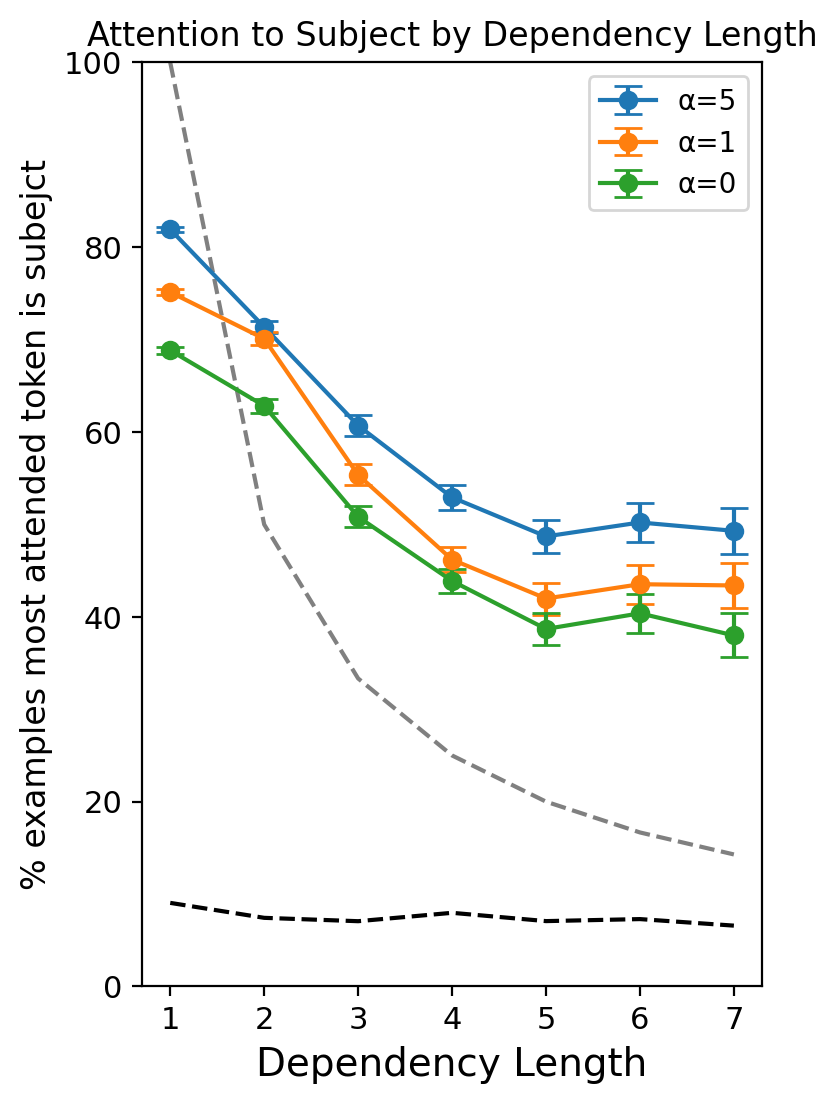

In [36]:
from matplotlib.pyplot import figure
ccg_tag_5_models = ['cbrnn_256_5_soft_2398.pt', 'cbrnn_256_5_soft_2399.pt', 
                    'cbrnn_256_5_soft_2400.pt', 'cbrnn_256_5_soft_2401.pt', 'cbrnn_256_5_soft_2402.pt']
ccg_tag_1_models = ['cbrnn_256_1_soft_2398.pt', 'cbrnn_256_1_soft_2399.pt', 
                    'cbrnn_256_1_soft_2400.pt', 'cbrnn_256_1_soft_2401.pt', 'cbrnn_256_1_soft_2402.pt']

ccg_tag_0_models = ['cbrnn_256_0_soft_2398.pt', 'cbrnn_256_0_soft_2399.pt', 
                    'cbrnn_256_0_soft_2400.pt', 'cbrnn_256_0_soft_2401.pt', 'cbrnn_256_0_soft_2402.pt']

print('Attention to subject at verb by nsubj length:')
print('{}:\t{}\t{}\t{}'.format('len.', 'acc.', 'conf.int.', 'count'))
dep_distance = []
ccg_tag_5_accs = []
ccg_tag_5_err_upper = []
ccg_tag_5_err_lower = []
ccg_tag_1_accs = []
ccg_tag_1_err_upper = []
ccg_tag_1_err_lower = []
ccg_tag_0_accs = []
ccg_tag_0_err_upper = []
ccg_tag_0_err_lower = []
dep_chance = []
total_chance = []
for i in range(1, 8):
    dep_distance.append(i)
    dep_chance.append((1/(i)) * 100)
    dep_length_i = nsubj_data[nsubj_data['dep_distance'] == i]
    avg_left_context_words = dep_length_i['head_ind'].mean() #num left context words is equal to index of verb
    total_chance.append((1 / avg_left_context_words) * 100)
    if(len(dep_length_i) > 0): #make sure there are examples of this dependency length
        dep_length_i_correct_by_model = 0
        for model_id in ccg_tag_5_models:
            dep_length_i_correct_by_model += len(dep_length_i[dep_length_i['overall_correct_' + model_id]])
        prop_ci = proportion_confint(dep_length_i_correct_by_model, (len(dep_length_i) * len(ccg_tag_5_models)))
        overall_acc = (dep_length_i_correct_by_model / (len(dep_length_i) * len(ccg_tag_5_models))) * 100
        ccg_tag_5_accs.append(overall_acc)
        err_lower = np.abs((prop_ci[0] * 100) - overall_acc)
        err_upper = (np.abs(prop_ci[1] * 100) - overall_acc)
        ccg_tag_5_err_lower.append(err_lower)
        ccg_tag_5_err_upper.append(err_upper)
        
        dep_length_i_correct_by_model = 0
        for model_id in ccg_tag_1_models:
            dep_length_i_correct_by_model += len(dep_length_i[dep_length_i['overall_correct_' + model_id]])
        prop_ci = proportion_confint(dep_length_i_correct_by_model, (len(dep_length_i) * len(ccg_tag_1_models)))
        overall_acc = (dep_length_i_correct_by_model / (len(dep_length_i) * len(ccg_tag_1_models))) * 100
        ccg_tag_1_accs.append(overall_acc)
        err_lower = np.abs((prop_ci[0] * 100) - overall_acc)
        err_upper = (np.abs(prop_ci[1] * 100) - overall_acc)
        ccg_tag_1_err_lower.append(err_lower)
        ccg_tag_1_err_upper.append(err_upper)
        
        dep_length_i_correct_by_model = 0
        for model_id in ccg_tag_0_models:
            dep_length_i_correct_by_model += len(dep_length_i[dep_length_i['overall_correct_' + model_id]])
        prop_ci = proportion_confint(dep_length_i_correct_by_model, (len(dep_length_i) * len(ccg_tag_0_models)))
        overall_acc = (dep_length_i_correct_by_model / (len(dep_length_i) * len(ccg_tag_0_models))) * 100
        ccg_tag_0_accs.append(overall_acc)
        err_lower = np.abs((prop_ci[0] * 100) - overall_acc)
        err_upper = (np.abs(prop_ci[1] * 100) - overall_acc)
        ccg_tag_0_err_lower.append(err_lower)
        ccg_tag_0_err_upper.append(err_upper)

figure(figsize=(4, 6), dpi=200)  

plt.errorbar(dep_distance, ccg_tag_5_accs, yerr = [ccg_tag_5_err_lower, ccg_tag_5_err_upper], capsize=5, label = "α=5", marker='o',linestyle="-")
plt.errorbar(dep_distance, ccg_tag_1_accs, yerr = [ccg_tag_1_err_lower, ccg_tag_1_err_upper], capsize=5, label = "α=1", marker='o',linestyle="-")
plt.errorbar(dep_distance, ccg_tag_0_accs, yerr = [ccg_tag_0_err_lower, ccg_tag_0_err_upper], capsize=5, label = "α=0", marker='o',linestyle="-")
plt.plot(dep_distance, dep_chance, linestyle="--", color='gray')
plt.plot(dep_distance, total_chance, linestyle="--", color='black')
plt.ylim(0, 100)
plt.title("Attention to Subject by Dependency Length", fontsize=12)
plt.xlabel("Dependency Length", fontsize=14)
plt.ylabel("% examples most attended token is subejct", fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.legend()
plt.show()

Attention to subject at verb by #distractor nouns between subj and verb
num::	overall	nouns	count


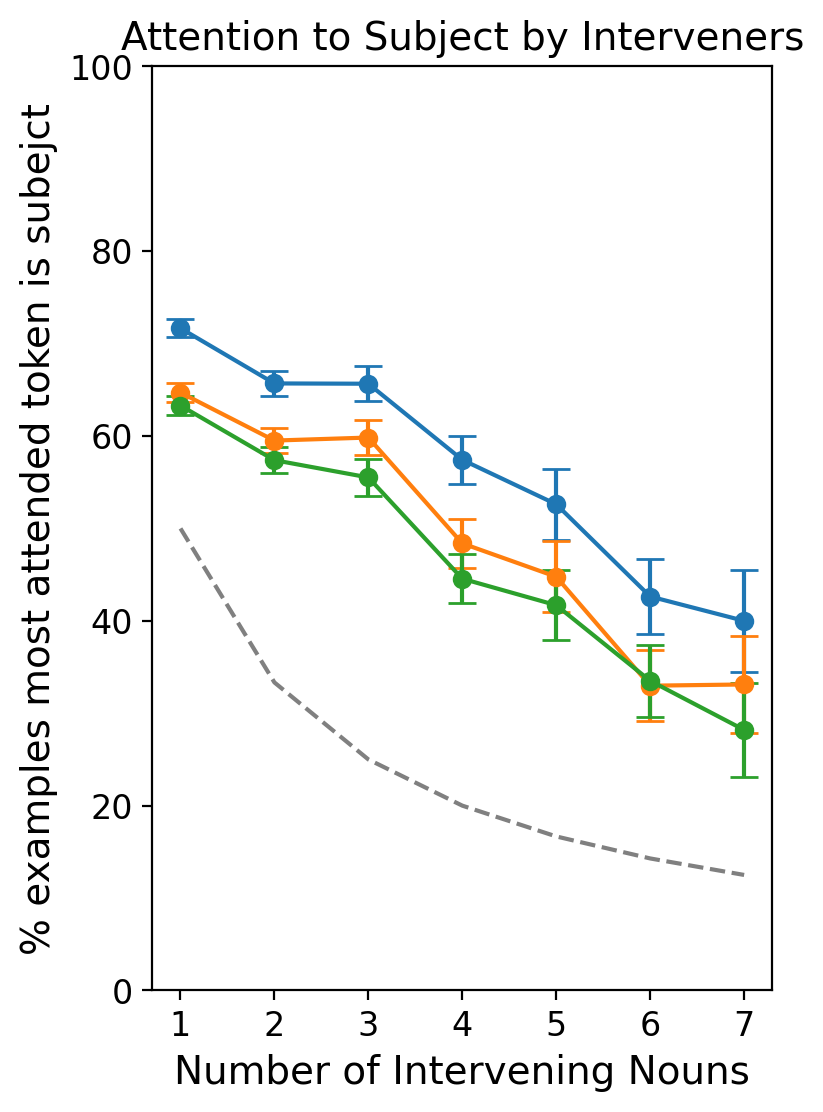

In [37]:
ccg_tag_5_models = ['cbrnn_256_5_soft_2398.pt', 'cbrnn_256_5_soft_2399.pt', 
                    'cbrnn_256_5_soft_2400.pt', 'cbrnn_256_5_soft_2401.pt', 'cbrnn_256_5_soft_2402.pt']
ccg_tag_1_models = ['cbrnn_256_1_soft_2398.pt', 'cbrnn_256_1_soft_2399.pt', 
                    'cbrnn_256_1_soft_2400.pt', 'cbrnn_256_1_soft_2401.pt', 'cbrnn_256_1_soft_2402.pt']
ccg_tag_0_models = ['cbrnn_256_0_soft_2398.pt', 'cbrnn_256_0_soft_2399.pt', 
                    'cbrnn_256_0_soft_2400.pt', 'cbrnn_256_0_soft_2401.pt', 'cbrnn_256_0_soft_2402.pt']

print('Attention to subject at verb by #distractor nouns between subj and verb')
print('{}:\t{}\t{}\t{}'.format('num:', 'overall', 'nouns', 'count'))
num_distr = []
ccg_tag_5_accs = []
ccg_tag_5_err_upper = []
ccg_tag_5_err_lower = []

ccg_tag_1_accs = []
ccg_tag_1_err_upper = []
ccg_tag_1_err_lower = []

ccg_tag_0_accs = []
ccg_tag_0_err_upper = []
ccg_tag_0_err_lower = []
noun_chance = []
for i in range(1,8):
    num_distr.append(i)
    noun_chance.append((1/(i+1)) * 100)
    num_distractors_i = nsubj_data[nsubj_data['intervening_distractors'] == i]
    if(len(num_distractors_i) > 0):
        num_distractors_i_correct_by_model = 0
        for model_id in ccg_tag_5_models:
            num_distractors_i_correct_by_model += len(num_distractors_i[num_distractors_i['subj_and_intv_nouns_correct_' + model_id]])
        num_distractors_i_total = (len(num_distractors_i) * len(ccg_tag_5_models))
        prop_ci = proportion_confint(num_distractors_i_correct_by_model, num_distractors_i_total)
        noun_acc = (num_distractors_i_correct_by_model / num_distractors_i_total) * 100
        ccg_tag_5_accs.append(noun_acc)
        err_lower = np.abs((prop_ci[0] * 100) - noun_acc)
        err_upper = (np.abs(prop_ci[1] * 100) - noun_acc)
        ccg_tag_5_err_lower.append(err_lower)
        ccg_tag_5_err_upper.append(err_upper)

        
        num_distractors_i_correct_by_model = 0
        for model_id in ccg_tag_1_models:
            num_distractors_i_correct_by_model += len(num_distractors_i[num_distractors_i['subj_and_intv_nouns_correct_' + model_id]])
        num_distractors_i_total = (len(num_distractors_i) * len(ccg_tag_1_models))
        prop_ci = proportion_confint(num_distractors_i_correct_by_model, num_distractors_i_total)
        noun_acc = (num_distractors_i_correct_by_model / num_distractors_i_total) * 100
        ccg_tag_1_accs.append(noun_acc)
        err_lower = np.abs((prop_ci[0] * 100) - noun_acc)
        err_upper = (np.abs(prop_ci[1] * 100) - noun_acc)
        ccg_tag_1_err_lower.append(err_lower)
        ccg_tag_1_err_upper.append(err_upper)        
        
        
        num_distractors_i_correct_by_model = 0
        for model_id in ccg_tag_0_models:
            num_distractors_i_correct_by_model += len(num_distractors_i[num_distractors_i['subj_and_intv_nouns_correct_' + model_id]])
        num_distractors_i_total = (len(num_distractors_i) * len(ccg_tag_0_models))
        prop_ci = proportion_confint(num_distractors_i_correct_by_model, num_distractors_i_total)
        noun_acc = (num_distractors_i_correct_by_model / num_distractors_i_total) * 100
        ccg_tag_0_accs.append(noun_acc)
        err_lower = np.abs((prop_ci[0] * 100) - noun_acc)
        err_upper = (np.abs(prop_ci[1] * 100) - noun_acc)
        ccg_tag_0_err_lower.append(err_lower)
        ccg_tag_0_err_upper.append(err_upper)
figure(figsize=(4, 6), dpi=200)    
plt.errorbar(num_distr, ccg_tag_5_accs, yerr = [ccg_tag_5_err_lower, ccg_tag_5_err_upper], capsize=5, label = "α=5", marker='o',linestyle="-")
plt.errorbar(num_distr, ccg_tag_1_accs, yerr = [ccg_tag_1_err_lower, ccg_tag_1_err_upper], capsize=5, label = "α=1", marker='o',linestyle="-")
plt.errorbar(num_distr, ccg_tag_0_accs, yerr = [ccg_tag_0_err_lower, ccg_tag_0_err_upper], capsize=5, label = "α=0", marker='o',linestyle="-")
plt.plot(num_distr, noun_chance, linestyle="--", color='gray')
plt.title("Attention to Subject by Interveners", fontsize=14)
plt.ylabel("% examples most attended noun is the subejct")
plt.ylim(0, 100)
plt.xlabel("Number of Intervening Nouns", fontsize=14)
plt.ylabel("% examples most attended token is subejct", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#plt.legend()
plt.show()


### Part 3: Targeted Psycholinguistic Evaluation
Section 4.2 of the paper - Here, I evaluate whether the models capture human processing effects from [Laurinavichyute and von der Malsburg (2021)](https://onlinelibrary.wiley.com/doi/full/10.1111/cogs.13086)
               
This python notebook only processes the data for the analysis.RMd file, which is where all statistical analyses are computed and plots are generated.

The original file from the Laurinavichyute and von der Malsburg (2021) is available as exp3.csv - We make some minor modifications to the stimuli which are discussed in Appendix A of our paper.

In [41]:
l_and_m_exp_3_data = pd.read_csv('./emnlp_analysis_data/laurinavichyute_malsburg_2021/exp3_no_compounds.csv', sep='\t')

In [43]:
model_outputs = []
condition_key = {'a':{'attraction':'none','violation':'grammatical'},
                'b':{'attraction':'grammatical','violation':'grammatical'},
                'c':{'attraction':'none','violation':'semantic'},
                'd':{'attraction':'semantic','violation':'semantic'},
                'e':{'attraction':'none','violation':'double'},
                'f':{'attraction':'double','violation':'double'},
                'g':{'attraction':'semantic','violation':'double'},
                'h':{'attraction':'grammatical','violation':'double'}}
for model_class in MODEL_CLASSES[:3]:
    for seed in SEEDS:
        model_id = "{}_{}.pt".format(model_class, seed)
        model = load_model(model_id)
        for i, row in l_and_m_exp_3_data.iterrows():
            model_input_toks = row['head'].split()
            subj_idx = len(model_input_toks) - 1
            model_input_toks.extend(row['ppmod'].split())
            dist_idx = len(model_input_toks) - 1
            model_input_toks.extend(row['adverb'].split())
            model_input_toks.extend(row['verb'].split())
            if(len(row['verb'].split()) > 1):
                verb_idx = len(model_input_toks) - 2
            else:
                verb_idx = len(model_input_toks) - 1
            
            model_input = tokenize_sent(model_input_toks)[0]
            if(model_id[:5] == 'cbrnn'):
                out_logits, _, _, attn_weights = model_forward(model, model_input, output_attn=True)
                attn_weights = attn_weights['weights']
                out_logits = out_logits.squeeze()
                out_surps = -log_softmax(out_logits)
                target_refl_surp = out_surps[verb_idx-1,model_input[verb_idx]].item()

                attn_weights = [x[0,1:] for x in attn_weights]
                target_attn_dist = attn_weights[verb_idx].numpy()
                attn_to_target = target_attn_dist[subj_idx]
                attn_to_distractor = target_attn_dist[dist_idx]
                attn_entropy = entropy(target_attn_dist)

                condition = row['condition']
                attraction = condition_key[condition]['attraction']
                violation = condition_key[condition]['violation']
                model_output = {'item':row['New.item.no'],'condition':condition,'attraction':attraction,'violation':violation,
                                'model':model_id[:-3],'model_type':model_id[:-8],'model_arch':'cbrnn','surp':target_refl_surp,
                                'target_attn':attn_to_target,'dist_attn':attn_to_distractor,'attn_entropy':attn_entropy}
                model_outputs.append(model_output)
            else:
                out_logits, _, _, _ = model_forward(model, model_input, model_type='lstm')
                out_logits = out_logits.squeeze()
                out_surps = -log_softmax(out_logits)
                target_refl_surp = out_surps[verb_idx-1,model_input[verb_idx]].item()

                condition = row['condition']
                attraction = condition_key[condition]['attraction']
                violation = condition_key[condition]['violation']
                model_output = {'item':row['New.item.no'],'condition':condition,'attraction':attraction,'violation':violation,
                                'model':model_id[:-3],'model_type':model_id[:-8],'model_arch':'lstm','surp':target_refl_surp,
                                'target_attn':None,'dist_attn':None,'attn_entropy':None}
                model_outputs.append(model_output)

l_and_m_exp_3_output_data = pd.DataFrame(model_outputs)
l_and_m_exp_3_output_data.to_csv('./emnlp_analysis_data/laurinavichyute_malsburg_2021/exp3_results.csv')

### Generate GPT-2 results
(Requires the huggingface transformers library and GPT-2 small)

In [44]:
from transformers import AutoTokenizer, GPT2LMHeadModel
import torch
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [45]:
#defining some helper functions
def tokenize_gpt2(input_toks):
    input_toks_split = input_toks.lower().split()
    data_tok_split = [input_toks_split[0]] + [' ' + x for x in input_toks_split[1:]]
    model_toks = tokenizer(input_toks.lower(), return_tensors="pt")
    subtok_map = [(x, tokenizer.encode(x, add_special_tokens=False)) for i, x in enumerate(data_tok_split)]
    word2tok_inds = []
    curr_tok = 0
    for i, x in enumerate(subtok_map):
        subtok_inds = []
        for subtok in x[1]:
            subtok_inds.append(curr_tok)
            curr_tok += 1
        word2tok_inds.append(subtok_inds)
    return model_toks, subtok_map, word2tok_inds

def get_surps_gpt2(out_logits, in_toks):
    logit_surps = -log_softmax(out_logits[0])
    out_surps = [-1]
    for i, tok in enumerate(in_toks[0][1:]):
        out_surps.append(logit_surps[i,tok].item())
    return np.array(out_surps)

In [46]:
model_outputs = []
unks_in_dataset = set()
condition_key = {'a':{'attraction':'none','violation':'grammatical'},
                'b':{'attraction':'grammatical','violation':'grammatical'},
                'c':{'attraction':'none','violation':'semantic'},
                'd':{'attraction':'semantic','violation':'semantic'},
                'e':{'attraction':'none','violation':'double'},
                'f':{'attraction':'double','violation':'double'},
                'g':{'attraction':'semantic','violation':'double'},
                'h':{'attraction':'grammatical','violation':'double'}}

syntactic_head_idxs = [(4,3), (3,6), (6,0), (2,9)]


for i, row in tqdm(l_and_m_exp_3_data.iterrows(), total=l_and_m_exp_3_data.shape[0]):
    model_input_toks = row['head'].split()
    subj_idx = len(model_input_toks) - 1
    model_input_toks.extend(row['ppmod'].split())
    dist_idx = len(model_input_toks) - 1
    model_input_toks.extend(row['adverb'].split())
    model_input_toks.extend(row['verb'].split())
    if(len(row['verb'].split()) > 1):
        verb_idx = len(model_input_toks) - 2
    else:
        verb_idx = len(model_input_toks) - 1

    model_toks, subtok_map, word2tok_inds = tokenize_gpt2(" ".join(model_input_toks).lower())

    verb_idx_to_tok_idx = word2tok_inds[verb_idx]
    subj_idx_to_tok_idx = word2tok_inds[subj_idx]
    dist_idx_to_tok_idx = word2tok_inds[dist_idx]

    outputs = model(**model_toks, output_attentions=True)
    attn_weights = outputs['attentions']
    out_logits = outputs['logits']
    out_surps = get_surps_gpt2(out_logits, model_toks['input_ids'])
    target_surp = out_surps[verb_idx_to_tok_idx].sum()

    for syntactic_head_idx in syntactic_head_idxs:
        target_attn_dist = attn_weights[syntactic_head_idx[0]][:,syntactic_head_idx[1],verb_idx_to_tok_idx,:].mean(axis=0)[0].detach().numpy()
        attn_to_target = target_attn_dist[subj_idx_to_tok_idx].sum()
        attn_to_distractor = target_attn_dist[dist_idx_to_tok_idx].sum()
        attn_entropy = entropy(target_attn_dist)

        condition = row['condition']
        attraction = condition_key[condition]['attraction']
        violation = condition_key[condition]['violation']
        model_output = {'item':row['New.item.no'],'condition':condition,'attraction':attraction,'violation':violation,
                        'model':f'gpt2_{syntactic_head_idx[0]}_{syntactic_head_idx[1]}',
                        'model_type':f'gpt2',
                        'model_arch':'gpt2','surp':target_surp,
                        'target_attn':attn_to_target,'dist_attn':attn_to_distractor,'attn_entropy':attn_entropy}
        model_outputs.append(model_output)


l_and_m_exp_3_output_data = pd.DataFrame(model_outputs)
l_and_m_exp_3_output_data.to_csv('./emnlp_analysis_data/laurinavichyute_malsburg_2021/exp3_results_gpt2.csv')

  0%|          | 0/216 [00:00<?, ?it/s]